In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import joblib
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import re
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
#Đọc hình ảnh
def load_images(image_folder):
  images = []
  labels = []
  class_names = os.listdir(image_folder)
  for label, class_name in enumerate(class_names):
    class_path = os.path.join(image_folder, class_name)
    for img_name in os.listdir(class_path):
      img_path = os.path.join(class_path, img_name)
      img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
      if img is not None:
        images.append(img)
        labels.append(label)
  return np.array(images), np.array(labels), class_names

In [ ]:
dataset_path = '/content/drive/My Drive/CS231/Dataset/'

train_folder = os.path.join(dataset_path, 'train')
X_train, y_train, class_names = load_images(train_folder)

test_folder = os.path.join(dataset_path, 'test')
X_test, y_test, _ = load_images(test_folder)

In [ ]:
#Trích xuất đặc trưng bằng SIFT
def extract_sift_features(images):
  sift = cv2.SIFT_create()
  descriptor_list = []
  for image in images:
    keypoints, descriptor = sift.detectAndCompute(image, None)
    descriptor_list.append(descriptor)
  return descriptor_list

In [ ]:
#Xây dựng từ điển visual words
def build_bovw(descriptor_list, k):
    all_descriptors = np.vstack(descriptor_list)

    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(all_descriptors)

    save_path = f"/content/drive/My Drive/CS231/Source_code/Bovw/Model/Kmeans_bovw/kmeans_bovw_{k}.pkl"
    joblib.dump(kmeans, save_path)
    print(f"KMeans model saved at: {save_path}")

    return kmeans

#Biểu diễn hình ảnh dưới dạng vector Bovw
def compute_bovw_historgram(descriptor_list, kmeans, k):
  histograms = []
  for descriptor in descriptor_list:
    histogram = np.zeros(k)
    if descriptor is not None:
      cluster_assignments = kmeans.predict(descriptor)
      for cluster_id in cluster_assignments:
        histogram[cluster_id] += 1
    histograms.append(histogram)
  return np.array(histograms)

#Chuẩn hóa vector Bovw
def normalize_bovw(bovw_features):
  scaler = StandardScaler()
  return scaler.fit_transform(bovw_features)

def bovw(descriptor_list, k):
  kmeans = build_bovw(descriptor_list, k)
  bovw_features = compute_bovw_historgram(descriptor_list, kmeans, k)
  bovw_features = normalize_bovw(bovw_features)
  return bovw_features, kmeans

In [ ]:
descriptor_list_train = extract_sift_features(X_train)
descriptor_list_test = extract_sift_features(X_test)

In [ ]:
#Hàm huấn luyện model với GridSearch
def train_model_with_gridsearch(X_train, y_train, model, param_grid):
  grid_search = GridSearchCV(
      estimator = model,
      param_grid = param_grid,
      cv=5,
      scoring='accuracy',
      n_jobs=-1)
  grid_search.fit(X_train, y_train)
  return grid_search

In [ ]:
#Hàm đánh giá và in kết quả
def evaluate_model(model, X_test, y_test, class_names):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=class_names)
    print("\nClassification Report:")
    print(report)
    return report

In [ ]:
#Lưu kết quả huấn luyện
def save_results(results_file, cv_results, best_params, best_score):
  with open(results_file, 'w') as f:
    for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
      line = f"Mean Accuracy: {mean_score:.6f}, Parameters: {params}"
      print(line)
      f.write(line + '\n')
    f.write(f"Best parameters: {best_params}\n")
    f.write(f"Best score: {best_score:.6f}\n")


In [ ]:
#Lưu model đã huấn luyện
def save_model(model, model_path, model_name):
    os.makedirs(model_path, exist_ok=True)
    model_file = os.path.join(model_path, model_name)
    joblib.dump(model, model_file)
    print(f"Model saved to {model_file}")
    return model_file

In [ ]:
model_path = '/content/drive/My Drive/CS231/Source_code/Bovw/Model/'
results_path = '/content/drive/My Drive/CS231/Source_code/Bovw/Result'

In [ ]:
k=200
kmeans = build_bovw(descriptor_list_train, k)
bovw_features_train = compute_bovw_historgram(descriptor_list_train, kmeans, k)
bovw_features_train = normalize_bovw(bovw_features_train)
bovw_features_test = compute_bovw_historgram(descriptor_list_test, kmeans, k)
bovw_features_test = normalize_bovw(bovw_features_test)

KMeans model saved at: /content/drive/My Drive/CS231/Source_code/Bovw/Model/Kmeans_bovw/kmeans_bovw_200.pkl


In [ ]:
#Huấn luyện và đánh giá KNN
knn_params = {'n_neighbors': range(1,15),
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']
              }
knn_grid = train_model_with_gridsearch(
    X_train=bovw_features_train,
    y_train=y_train,
    model=KNeighborsClassifier(),
    param_grid=knn_params)

os.makedirs(results_path, exist_ok=True)
results_file = os.path.join(results_path, f'result_knn_{k}.txt')
save_results(results_file, knn_grid.cv_results_, knn_grid.best_params_, knn_grid.best_score_)

print("Best parameters for KNN:", knn_grid.best_params_)
print("Best KNN score:", knn_grid.best_score_)

evaluate_model(knn_grid.best_estimator_, bovw_features_test, y_test, class_names)

save_model(knn_grid.best_estimator_, model_path, f'knn_model_{k}.pkl')

Mean Accuracy: 0.534318, Parameters: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Mean Accuracy: 0.534318, Parameters: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
Mean Accuracy: 0.499980, Parameters: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
Mean Accuracy: 0.534318, Parameters: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
Mean Accuracy: 0.542348, Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Mean Accuracy: 0.546394, Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Mean Accuracy: 0.539287, Parameters: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'uniform'}
Mean Accuracy: 0.553419, Parameters: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
Mean Accuracy: 0.536247, Parameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Mean Accuracy: 0.554424, Parameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights

'/content/drive/My Drive/CS231/Source_code/Bovw/Model/knn_model_200.pkl'

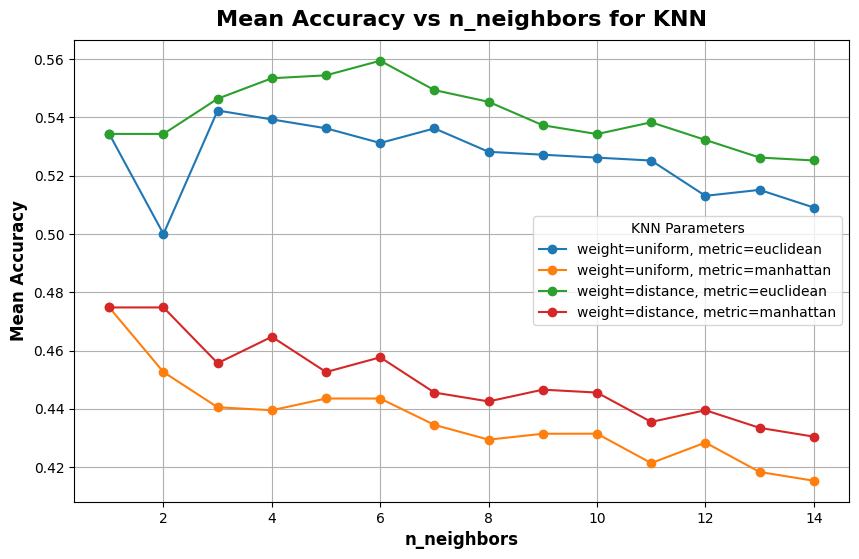

In [ ]:
def plot_knn_results(knn_grid):
    mean_accuracy = knn_grid.cv_results_['mean_test_score']
    n_neighbors = knn_grid.cv_results_['param_n_neighbors'].data
    weights = knn_grid.cv_results_['param_weights'].data
    metric = knn_grid.cv_results_['param_metric'].data

    plt.figure(figsize=(10, 6))

    for weight in ['uniform', 'distance']:
        for met in ['euclidean', 'manhattan']:
            mask = (weights == weight) & (metric == met)
            if np.any(mask):
                plt.plot(n_neighbors[mask], mean_accuracy[mask], marker='o', label=f'weight={weight}, metric={met}')

    plt.title('Mean Accuracy vs n_neighbors for KNN', fontsize=16, fontweight='bold', pad=10)
    plt.xlabel('n_neighbors', fontsize=12, fontweight='bold')
    plt.ylabel('Mean Accuracy', fontsize=12, fontweight='bold')
    plt.legend(title="KNN Parameters")
    plt.grid(True)
    plt.show()

plot_knn_results(knn_grid)

In [ ]:
#Huấn luyện và đánh giá bằng SVM
svm_params = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

svm_grid = train_model_with_gridsearch(
    X_train=bovw_features_train,
    y_train=y_train,
    model=SVC(random_state=42),
    param_grid=svm_params)

os.makedirs(results_path, exist_ok=True)
results_file = os.path.join(results_path, f'result_svm_{k}.txt')
save_results(results_file, svm_grid.cv_results_, svm_grid.best_params_, svm_grid.best_score_)

print("Best parameters for SVM:", svm_grid.best_params_)
print("Best SVM score:", svm_grid.best_score_)

evaluate_model(svm_grid.best_estimator_, bovw_features_test, y_test, class_names)

save_model(svm_grid.best_estimator_, model_path, f'svm_model_{k}.pkl')

Mean Accuracy: 0.662347, Parameters: {'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}
Mean Accuracy: 0.236815, Parameters: {'C': 0.001, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Accuracy: 0.171372, Parameters: {'C': 0.001, 'gamma': 'scale', 'kernel': 'poly'}
Mean Accuracy: 0.662347, Parameters: {'C': 0.001, 'gamma': 'auto', 'kernel': 'linear'}
Mean Accuracy: 0.236815, Parameters: {'C': 0.001, 'gamma': 'auto', 'kernel': 'rbf'}
Mean Accuracy: 0.171372, Parameters: {'C': 0.001, 'gamma': 'auto', 'kernel': 'poly'}
Mean Accuracy: 0.722811, Parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Mean Accuracy: 0.236815, Parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Accuracy: 0.176412, Parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'poly'}
Mean Accuracy: 0.722811, Parameters: {'C': 0.01, 'gamma': 'auto', 'kernel': 'linear'}
Mean Accuracy: 0.236815, Parameters: {'C': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
Mean Accuracy: 0.175402, Parameters: {'C': 0.01, 'gamma': 'a

'/content/drive/My Drive/CS231/Source_code/Bovw/Model/svm_model_200.pkl'

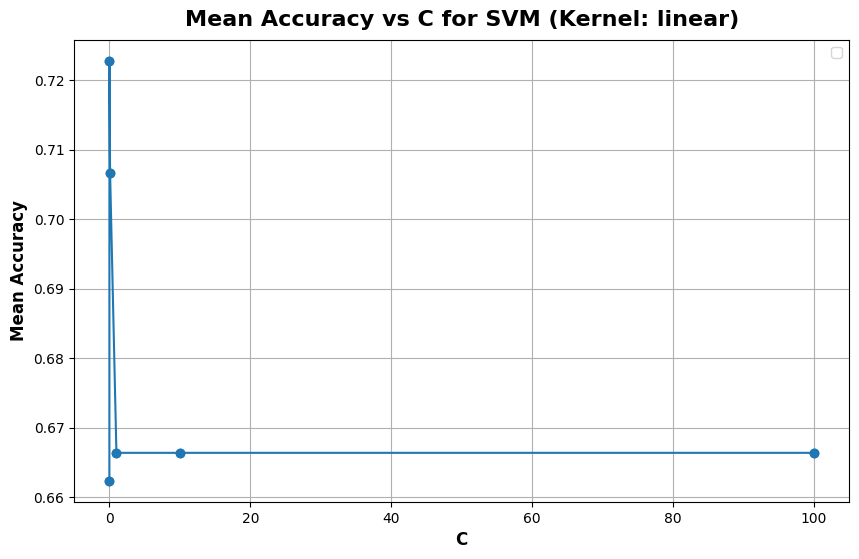

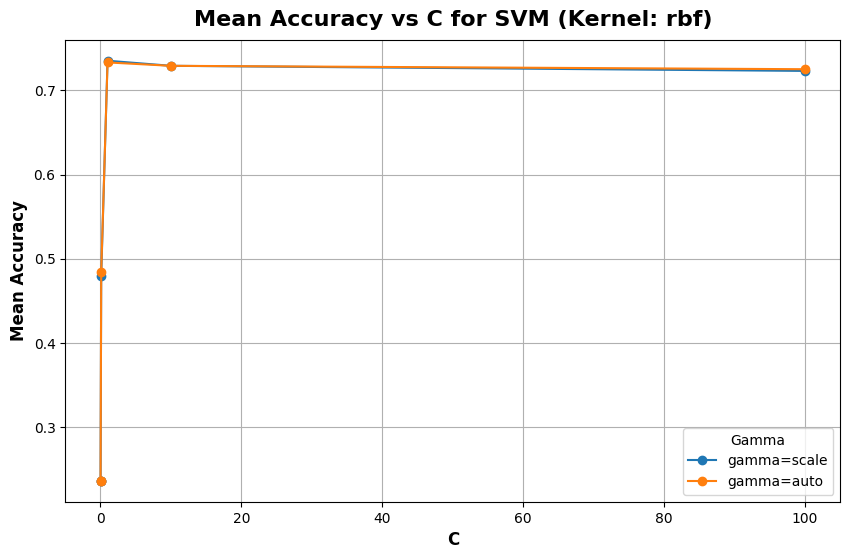

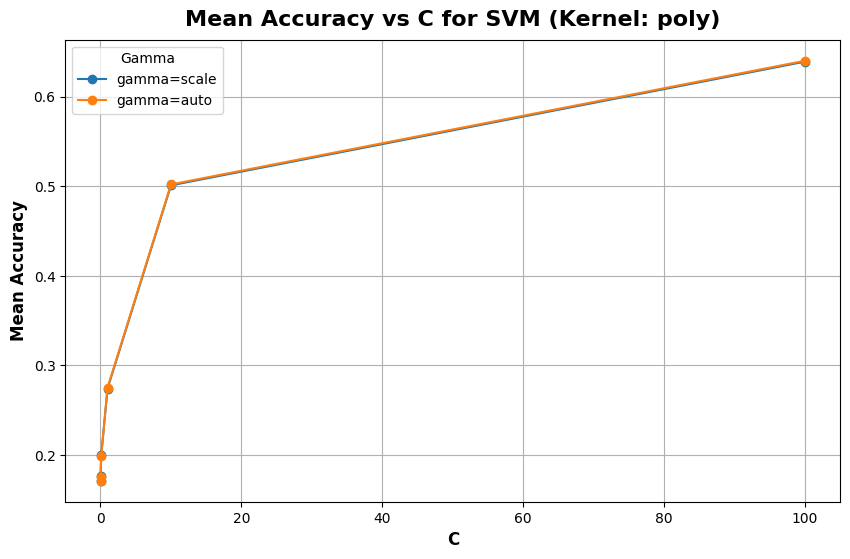

In [ ]:
def plot_svm_results(svm_grid):
    mean_accuracy = svm_grid.cv_results_['mean_test_score']
    kernel = svm_grid.cv_results_['param_kernel'].data
    C_values = svm_grid.cv_results_['param_C'].data
    gamma = svm_grid.cv_results_['param_gamma'].data

    kernels = ['linear', 'rbf', 'poly']

    for ker in kernels:
        plt.figure(figsize=(10, 6))
        if ker == 'linear':
            mask = (kernel == 'linear')
            if np.any(mask):
                plt.plot(C_values[mask], mean_accuracy[mask], marker='o')
        else:
            for gam in ['scale', 'auto']:
                mask = (kernel == ker) & (gamma == gam)
                if np.any(mask):
                    plt.plot(C_values[mask], mean_accuracy[mask], marker='o', label=f'gamma={gam}')

        plt.title(f'Mean Accuracy vs C for SVM (Kernel: {ker})', fontsize=16, fontweight='bold', pad=10)
        plt.xlabel('C', fontsize=12, fontweight='bold')
        plt.ylabel('Mean Accuracy', fontsize=12, fontweight='bold')
        plt.legend(title="Gamma" if ker != 'linear' else None)
        plt.grid(True)
        plt.show()

plot_svm_results(svm_grid)

In [ ]:
#Huấn luyện và đánh giá cho Random Forest
rf_params = {
    'n_estimators': [10, 50, 100, 150, 200, 250, 300, 350, 400, 500],
    'max_depth': [None, 10, 20, 30],
    }

rf_grid = train_model_with_gridsearch(
    X_train=bovw_features_train,
    y_train=y_train,
    model=RandomForestClassifier(random_state=42),
    param_grid=rf_params)

os.makedirs(results_path, exist_ok=True)
results_file = os.path.join(results_path, f'result_rf_{k}.txt')
save_results(results_file, rf_grid.cv_results_, rf_grid.best_params_, rf_grid.best_score_)

print("Best parameters for RF:", rf_grid.best_params_)
print("Best RF score:", rf_grid.best_score_)

evaluate_model(rf_grid.best_estimator_, bovw_features_test, y_test, class_names)

save_model(rf_grid.best_estimator_, model_path, f'rf_model_{k}.pkl')

Mean Accuracy: 0.617918, Parameters: {'max_depth': None, 'n_estimators': 10}
Mean Accuracy: 0.696574, Parameters: {'max_depth': None, 'n_estimators': 50}
Mean Accuracy: 0.708659, Parameters: {'max_depth': None, 'n_estimators': 100}
Mean Accuracy: 0.717766, Parameters: {'max_depth': None, 'n_estimators': 150}
Mean Accuracy: 0.718786, Parameters: {'max_depth': None, 'n_estimators': 200}
Mean Accuracy: 0.721816, Parameters: {'max_depth': None, 'n_estimators': 250}
Mean Accuracy: 0.727867, Parameters: {'max_depth': None, 'n_estimators': 300}
Mean Accuracy: 0.727877, Parameters: {'max_depth': None, 'n_estimators': 350}
Mean Accuracy: 0.730892, Parameters: {'max_depth': None, 'n_estimators': 400}
Mean Accuracy: 0.729882, Parameters: {'max_depth': None, 'n_estimators': 500}
Mean Accuracy: 0.624019, Parameters: {'max_depth': 10, 'n_estimators': 10}
Mean Accuracy: 0.685498, Parameters: {'max_depth': 10, 'n_estimators': 50}
Mean Accuracy: 0.704644, Parameters: {'max_depth': 10, 'n_estimators': 1

'/content/drive/My Drive/CS231/Source_code/Bovw/Model/rf_model_200.pkl'

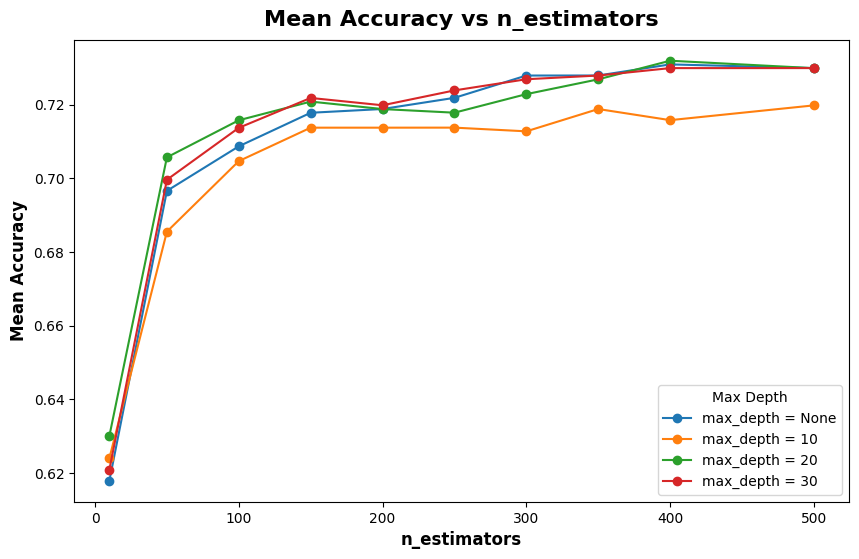

In [ ]:
# Trích xuất kết quả và tạo biểu đồ cho RF
def plot_rf():
    mean_accuracy = rf_grid.cv_results_['mean_test_score']
    n_estimators = rf_grid.cv_results_['param_n_estimators'].data
    max_depth = rf_grid.cv_results_['param_max_depth'].data

    plt.figure(figsize=(10, 6))

    mask = (max_depth == None)
    if np.any(mask):
        plt.plot(n_estimators[mask], mean_accuracy[mask], marker='o', label='max_depth = None')
    for depth in [10, 20, 30]:
        mask = (max_depth == depth)
        plt.plot(n_estimators[mask], mean_accuracy[mask], marker='o', label=f'max_depth = {depth}')

    plt.title('Mean Accuracy vs n_estimators', fontsize=16, fontweight='bold', pad=10)
    plt.xlabel('n_estimators', fontsize=12, fontweight='bold')
    plt.ylabel('Mean Accuracy', fontsize=12, fontweight='bold')
    plt.legend(title="Max Depth")
    plt.show()
plot_rf()


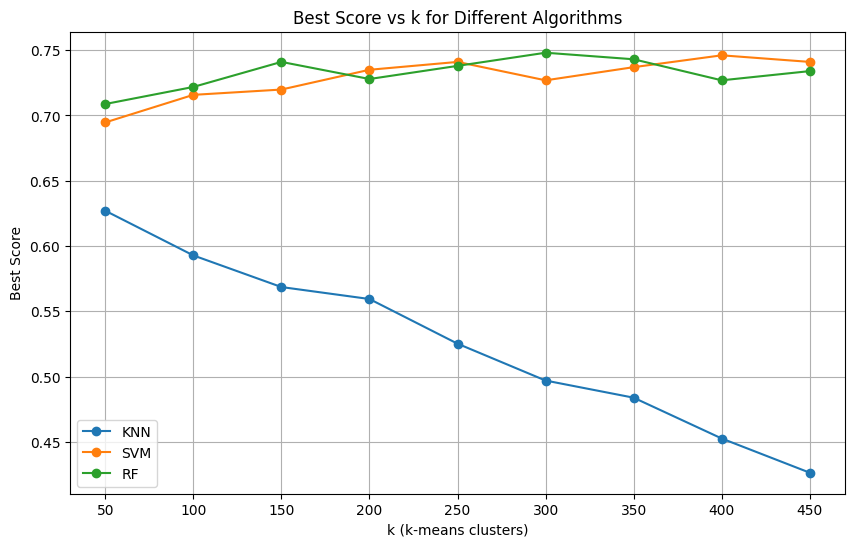

In [ ]:
# Hàm đọc Best Score từ file
def read_best_score(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith("Best score:"):
                # Trích xuất giá trị Best score
                return float(re.search(r"Best score: ([0-9.]+)", line).group(1))
    return None

# Hàm đọc và nhóm kết quả theo thuật toán
def group_scores_by_algorithm(results_folder):
    grouped_scores = defaultdict(list)
    result_files = [os.path.join(results_folder, f) for f in os.listdir(results_folder) if f.endswith('.txt')]

    for file_path in result_files:
        # Tách tên thuật toán và giá trị k từ tên file
        file_name = os.path.basename(file_path)
        match = re.match(r'result_(\w+)_(\d+)', file_name)
        if match:
            algorithm = match.group(1)  # Thuật toán (knn, svm, rf)
            k_value = int(match.group(2))  # Giá trị k
            best_score = read_best_score(file_path)  # Đọc Best score
            if best_score is not None:
                grouped_scores[algorithm].append((k_value, best_score))

    # Sắp xếp danh sách theo giá trị k
    for algorithm in grouped_scores:
        grouped_scores[algorithm].sort(key=lambda x: x[0])

    return grouped_scores

# Hàm vẽ biểu đồ
def plot_scores(grouped_scores):
    plt.figure(figsize=(10, 6))

    for algorithm, scores in grouped_scores.items():
        k_values, best_scores = zip(*scores)
        plt.plot(k_values, best_scores, marker='o', linestyle='-', label=f"{algorithm.upper()}")

    plt.xlabel("k (k-means clusters)")
    plt.ylabel("Best Score")
    plt.title("Best Score vs k for Different Algorithms")
    plt.legend()
    plt.grid(True)
    plt.show()

# Thư mục chứa các file kết quả
results_folder = '/content/drive/My Drive/CS231/Source_code/Bovw/Result'

# Đọc và nhóm kết quả
grouped_scores = group_scores_by_algorithm(results_folder)

# Vẽ biểu đồ
plot_scores(grouped_scores)
